In [9]:
import pandas as pd

train = pd.read_csv('/Users/minsun/Downloads/superconductivty+data/train.csv')

print(train.head())
print(train.shape) #데이터 크기
print(train.info()) #데이터 타입


   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607           

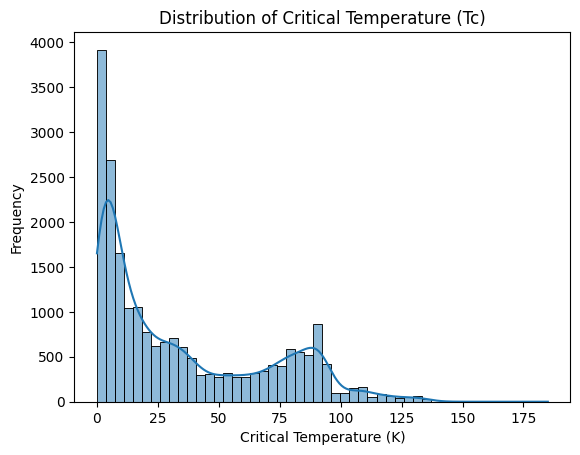

In [ ]:
# 2 목표 변수(Tc) 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train['critical_temp'], kde = True, bins = 50)
plt.title('Distribution of Critical Temperature (Tc)')
plt.xlabel('Critical Temperature (K)')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Tc와 다른 변수들의 상관관계 분석
corr = train.corr()['critical_temp'].sort_values(ascending=False)
print("Tc와 상관관계가 높은 변수 Top 10:")
print(corr.head(10))

Tc와 상관관계가 높은 변수 Top 10:
critical_temp                  1.000000
wtd_std_ThermalConductivity    0.721271
range_ThermalConductivity      0.687654
range_atomic_radius            0.653759
std_ThermalConductivity        0.653632
wtd_entropy_atomic_mass        0.626930
wtd_entropy_atomic_radius      0.603494
number_of_elements             0.601069
range_fie                      0.600790
wtd_std_atomic_radius          0.599199
Name: critical_temp, dtype: float64


### 출력된 상관관계 Top5 변수 ###
:critical_temp, wtd_std_ThermalConductivity,range_ThermalConductivity,range_atomic_radius,std_ThermalConductivity 

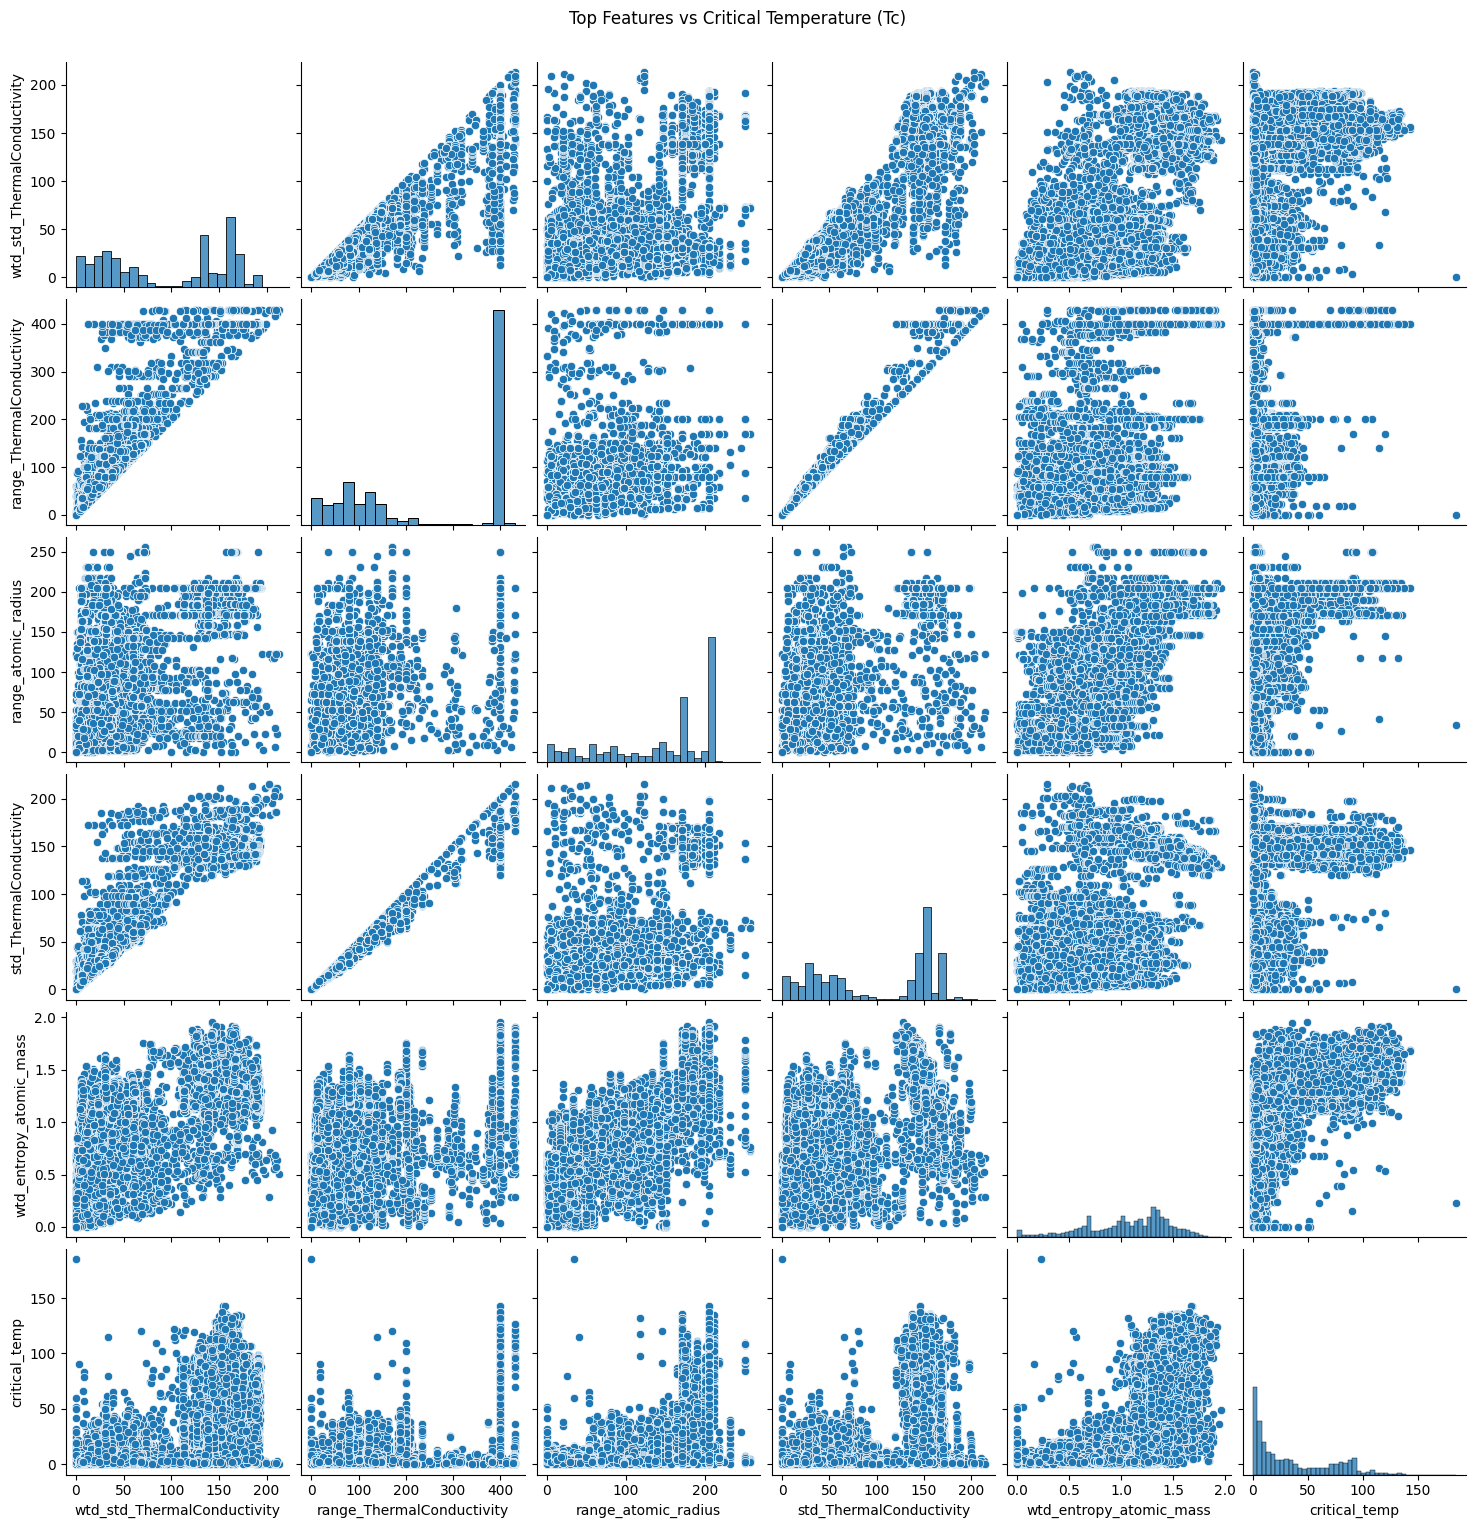

In [16]:
# 가장 상관이 높은 변수들만 골라서 시각화
top_corr_features = corr[1:6].index

import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(train[top_corr_features.to_list() + ['critical_temp']])
plt.suptitle('Top Features vs Critical Temperature (Tc)', y=1.02)
plt.show()



# 변수 해석 간단히 #
wtd_std_ThermalConductivity : 가중 표본편차 -> 다양한 열전도 특성 원소가 혼합될수록 Tc에 영향 가능
range_ThermalConductivity : 열전도도의 범위 -> 성분 간 전도도 차이가 클수록 특정 성질 강화 가능
range_atomic_radius : 원자 반지름의 범위 -> 격자 구조 변화, 전자구조 변화에 영향 가능
std_ThermalConductivity : 열전도도의 표준편차 -> 구성 원소의 열전도 다양성이 클수록 Tc 변화 폭 높음


In [ ]:
## 모델링
!pip3 install scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [18]:
# 주요 피처만 사용
features = ['wtd_std_ThermalConductivity','range_ThermalConductivity', 'range_atomic_radius', 'std_ThermalConductivity']
x = train[features]
y = train['critical_temp']

# 훈련 테스트 데이터 분활
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [21]:
# 선형회귀 모델
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

y_pred_lr = lr_model.predict(x_test)

print(f"선형회귀 모델 성능")
print("R2 Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

선형회귀 모델 성능
R2 Score: 0.5837211077480724
RMSE: 21.88996336804455


In [ ]:
# 랜덤포레스트 모델
import numpy as np

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(x_train, y_train)

y_pred_rf = rf_model.predict(x_test)

print(f"랜덤포레스트 모델 성능")
print("R2 Score:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


## 랜덤포레스트 장점 : 어떤 변수가 예측에 기여 했는지 직관적으로 보여준다

랜덤포레스트 모델 성능
R2 Score: 0.8650622838314896
RMSE: 12.462911681439703


두 모델의 R² 점수와 RMSE
: 선형회귀 모델 성능
R2 Score: 0.5837211077480724
RMSE: 21.88996336804455

: : 랜덤포레스트 모델 성능
R2 Score: 0.8650622838314896
RMSE: 12.462911681439703


예측력이 어느 쪽이 더 좋은지
: 랜덤포레스트 모델

✔️ R² 높을수록 모델 설명력이 좋음
✔️ RMSE 낮을수록 예측 오차가 적음
→ 랜덤 포레스트가 압도적으로 더 좋은 예측력 보여줌 🎯

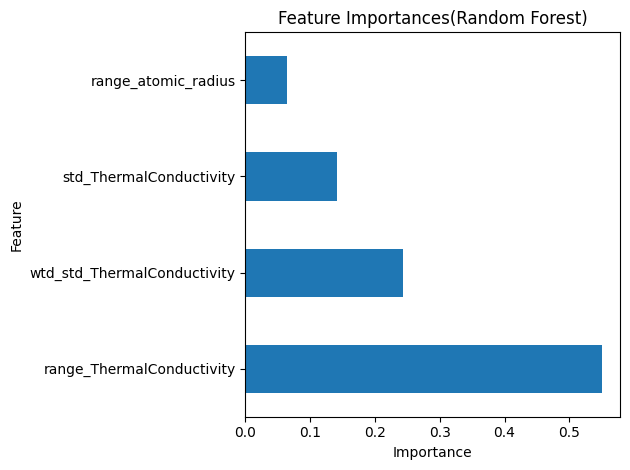

In [26]:
# 변수 중요도 시각화
import matplotlib.pyplot as plt
import pandas as pd

# 변수 중요도 추출
importances = rf_model.feature_importances_
features_names = x.columns

# 시리즈로 만들기
importances_series = pd.Series(importances, index = features_names).sort_values(ascending = False)

# 시각화
plt.Figure(figsize=(8,5))
importances_series.plot(kind = 'barh')
plt.title('Feature Importances(Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()





변수명	중요도	의미 & 해석
range_ThermalConductivity	0.50 이상	물질 구성 원소 간 열전도도의 차이 → 전자의 흐름이나 격자 진동에 큰 영향을 미침 → 초전도 현상에서 결정적인 역할 가능
wtd_std_ThermalConductivity	중간	원소별 열전도도의 가중 표준편차
std_ThermalConductivity	중간	단순 표준편차
range_atomic_radius	낮지만 유의	원자 크기 차이가 격자 구조 왜곡 → Tc에 영향 줄 수 있음

**“열전도도의 다양성과 그 차이가 클수록, 특정 초전도적 특성이 더 유리하게 형성될 수 있다”**

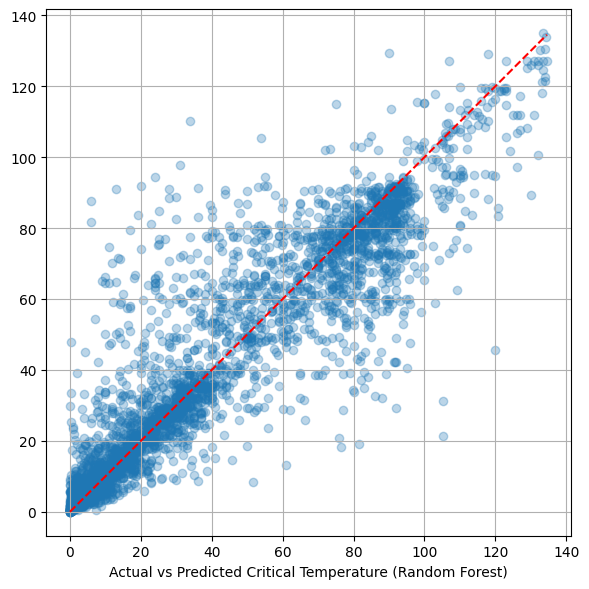

In [28]:
# 예측 Vs 실제
# 모델이 얼마나 “진짜 데이터와 가까운지” 직관적으로 보여줄 수 있음
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha = 0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color = 'red')
plt.xlabel('Actual vs Predicted Critical Temperature (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()
